In [3]:
pip install pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 27.5 MB/s eta 0:00:0000:010:01
  Using cached pytz-2024.1-py2.py3-none-any.whl (505 kB)
  Using cached tzdata-2024.1-py2.py3-none-any.whl (345 kB)

[notice] A new release of pip is available: 23.0.1 -> 24.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [12]:
pip install scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 26.3 MB/s eta 0:00:0000:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.9/29.9 MB 24.3 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.0.1 -> 24.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [14]:
pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 23.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 19.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.8/244.8 kB 6.8 MB/s eta 0:00:00
  Using cached kiwisolver-1.4.5-cp310-cp310-macosx_11_0_arm64.whl (66 kB)
  Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)

[notice] A new release of pip is available: 23.0.1 -> 24.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [15]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt

In [16]:
# Function to calculate the required features for a SMILES string
def calculate_features(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    string_length = len(smiles)
    num_chiral_centers = len(Chem.FindMolChiralCenters(mol, includeUnassigned=False))
    mol_weight = Descriptors.MolWt(mol)
    num_heavy_atoms = mol.GetNumHeavyAtoms()
    return [string_length, num_chiral_centers, mol_weight, num_heavy_atoms]

# Read the SMILES strings from the file
with open("combined_nps(absolute coconut).txt", "r") as file:
    smiles_list = file.readlines()

# Remove any leading/trailing whitespace
smiles_list = [s.strip() for s in smiles_list]

# Calculate features for each SMILES string
data = []
for smiles in smiles_list:
    features = calculate_features(smiles)
    if features:
        data.append([smiles] + features)

# Convert to a DataFrame
columns = ["smiles", "string_length", "num_chiral_centers", "mol_weight", "num_heavy_atoms"]
df = pd.DataFrame(data, columns=columns)


df.head()


[20:58:13] WARNING: not removing hydrogen atom without neighbors


,smiles,string_length,num_chiral_centers,mol_weight,num_heavy_atoms
0,CC=C(N=CS)C(=O)OC1C(COC(C)=O)OC(C2(O)CC(=O)C(N...,87,0,660.651,45
1,COc1cc(C)cc2c1C(=O)OC1C(O)C=CC3c4c(cc(OC)c5c4C...,78,0,598.604,44
2,COc1cc(C)cc2c1C(=O)O[C@@H]1[C@H](O)C=C[C@@H]3c...,100,5,598.604,44
3,COc1cc(C)cc2c1C(=O)OC1C(O)C=CC3c4c(cc(OC)c5c4C...,73,0,554.551,41
4,COc1cc(C)cc2c1C(=O)O[C@@H]1[C@H](O)C=C[C@@H]3c...,95,5,554.551,41


In [30]:
# Aggregate bins for stratification
df['string_length_bin'] = pd.cut(df['string_length'], bins=10, labels=False)
df['num_chiral_centers_bin'] = pd.cut(df['num_chiral_centers'], bins=5, labels=False)
df['mol_weight_bin'] = pd.cut(df['mol_weight'], bins=10, labels=False)
df['num_heavy_atoms_bin'] = pd.cut(df['num_heavy_atoms'], bins=5, labels=False)

# Create a combined feature for stratification
df['stratify_col'] = (
    df['string_length_bin'].astype(str) + "_" +
    df['num_chiral_centers_bin'].astype(str) + "_" +
    df['mol_weight_bin'].astype(str) + "_" +
    df['num_heavy_atoms_bin'].astype(str)
)

# Ensure that each class has at least two members
while df['stratify_col'].value_counts().min() < 2:
    if df['string_length_bin'].nunique() > 1:
        df['string_length_bin'] = pd.cut(df['string_length'], bins=df['string_length_bin'].nunique() - 1, labels=False)
    if df['num_chiral_centers_bin'].nunique() > 1:
        df['num_chiral_centers_bin'] = pd.cut(df['num_chiral_centers'], bins=df['num_chiral_centers_bin'].nunique() - 1, labels=False)
    if df['mol_weight_bin'].nunique() > 1:
        df['mol_weight_bin'] = pd.cut(df['mol_weight'], bins=df['mol_weight_bin'].nunique() - 1, labels=False)
    if df['num_heavy_atoms_bin'].nunique() > 1:
        df['num_heavy_atoms_bin'] = pd.cut(df['num_heavy_atoms'], bins=df['num_heavy_atoms_bin'].nunique() - 1, labels=False)
    
    df['stratify_col'] = (
        df['string_length_bin'].astype(str) + "_" +
        df['num_chiral_centers_bin'].astype(str) + "_" +
        df['mol_weight_bin'].astype(str) + "_" +
        df['num_heavy_atoms_bin'].astype(str)
    )

# Perform stratified sampling
sss = StratifiedShuffleSplit(n_splits=1, test_size=10000, random_state=42)
train_index, test_index = next(sss.split(df, df['stratify_col']))

train_df = df.iloc[train_index].drop(columns=['stratify_col', 'string_length_bin', 'num_chiral_centers_bin', 'mol_weight_bin', 'num_heavy_atoms_bin'])
test_df = df.iloc[test_index].drop(columns=['stratify_col', 'string_length_bin', 'num_chiral_centers_bin', 'mol_weight_bin', 'num_heavy_atoms_bin'])


train_df.head()



,smiles,string_length,num_chiral_centers,mol_weight,num_heavy_atoms
945262,Cn1cc(/C=C2/Oc3cc(OC(=O)N4CCOCC4)ccc3C2=O)c2cc...,51,0,404.422,30
395130,COC[C@H]1O[C@H](O[C@]2(C)CC[C@@H](C(C)(C)O)O[C...,185,16,945.198,66
553687,COc1cc2c(=O)c3c(O)cc(O)cc3oc2c(O)c1OC,37,0,304.254,22
598423,CC[C@@H](C)[C@H](NC(=O)[C@H]1Cc2ccccc2CN1)C(=O...,59,3,409.530,30
323482,COc1c2c(c(OC)c3occc13)OC(c1ccccc1)C(OC)C2OC,43,0,370.401,27


In [31]:
test_df.head()

,smiles,string_length,num_chiral_centers,mol_weight,num_heavy_atoms
1121165,CCOc1ccc(CO[C@H]2[C@@H]3OC4(CCCCC4)O[C@@H]3O[C...,75,5,474.594,34
127956,CC(C)C[C@H]1NC(=O)[C@H](C(C)C)OC(=O)[C@H](Cc2c...,122,6,735.919,53
7381,CCCCCCN1CC2(CN(Cc3ccccc3)CC3COCCN32)C1,38,0,357.542,26
872905,CN1C(=O)C2N=C(O)C1(C)SC21C(O)=Nc2ccccc21,40,0,303.343,21
978889,C/C=C/C(=O)C1C(C)=CC=CC1(C)C,28,0,190.286,14


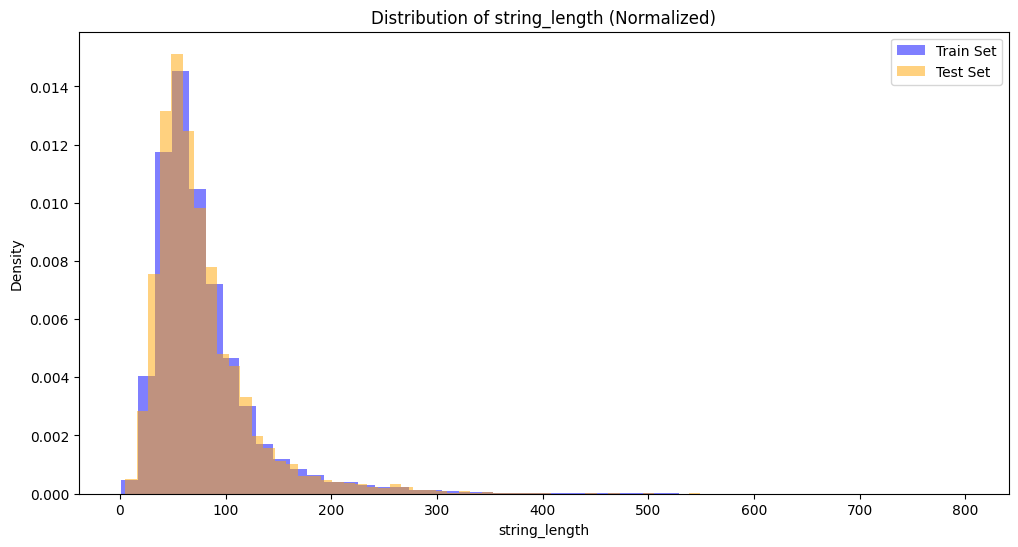

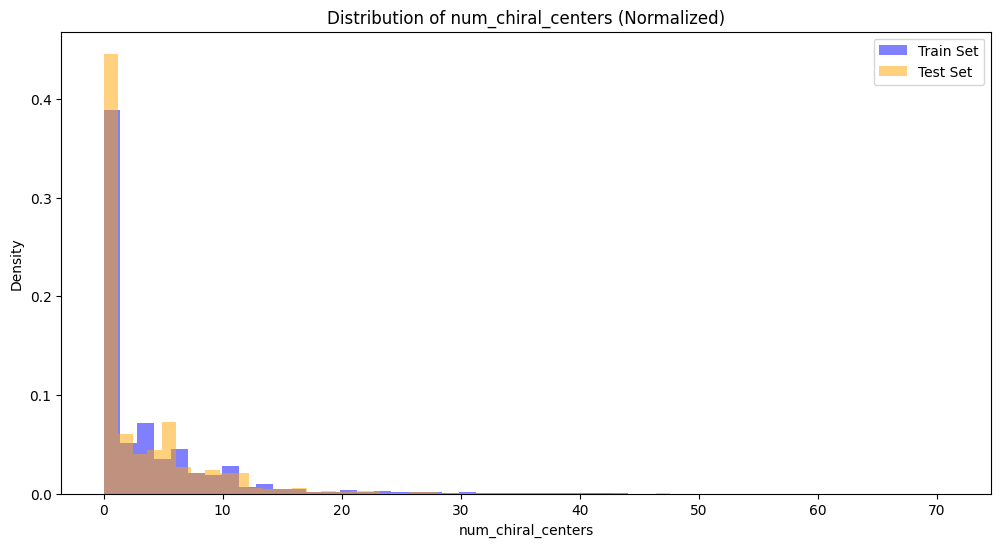

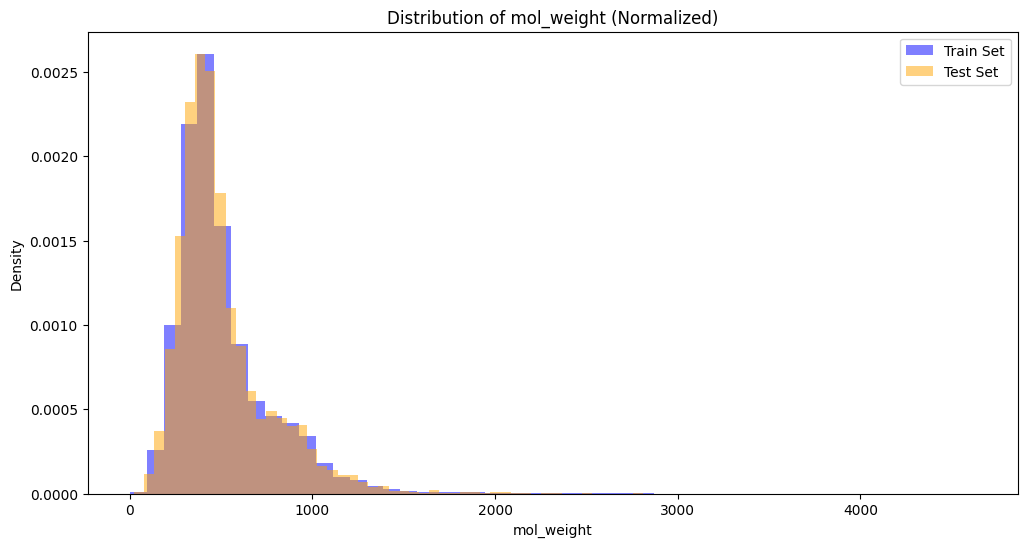

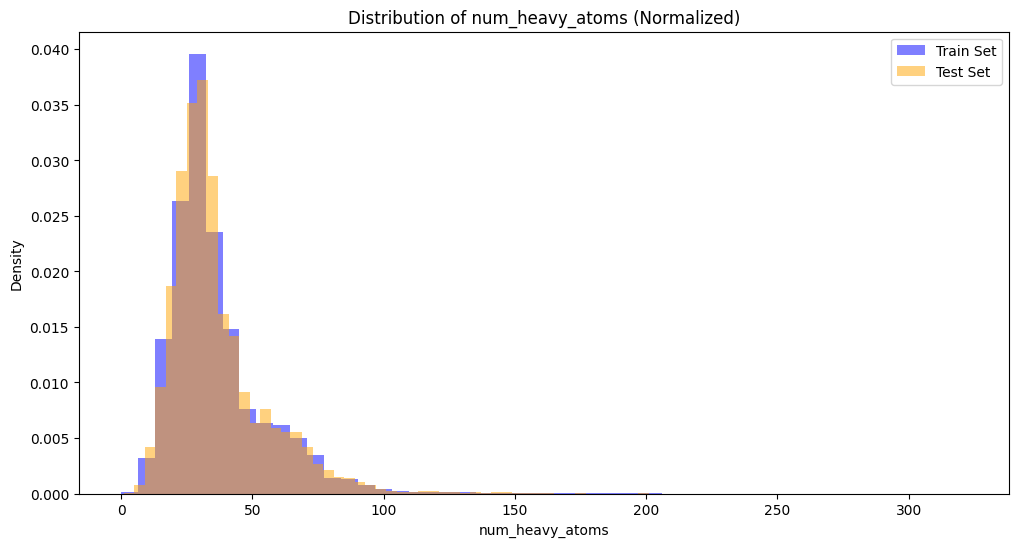

In [32]:
def plot_distribution(feature, train_df, test_df):
    plt.figure(figsize=(12, 6))
    plt.hist(train_df[feature], bins=50, alpha=0.5, label='Train Set', density=True, color='blue')
    plt.hist(test_df[feature], bins=50, alpha=0.5, label='Test Set', density=True, color='orange')
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.title(f'Distribution of {feature} (Normalized)')
    plt.legend(loc='upper right')
    plt.show()

# Plot normalized distributions for all features
features = ["string_length", "num_chiral_centers", "mol_weight", "num_heavy_atoms"]
for feature in features:
    plot_distribution(feature, train_df, test_df)


In [33]:
# Save the train and test sets to separate text files
train_df['smiles'].to_csv("./train.txt", index=False, header=False)
test_df['smiles'].to_csv("./test.txt", index=False, header=False)

train_df.shape, test_df.shape

((1133594, 5), (10000, 5))